Preprocessing steps: 

* Removing eyetracking data ouside of trials 
* Blinks and tracking noise were removed by excluding samples at which the pupil was lost entirely, excising data 100 ms before and 150 ms after each occurrence (replaced with NaN)
* Convert data to dva, Centering and flip Y-axis
* Remove slow signal drift by linear detrending and median-centering of the gaze position time series (X and Y) (assumes that the median gaze position corresponds to central fixation)
* Downsampling to 100 Hz (optional)
* Smoothing (Running average or Gaussian Kernel)


In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import glob 
import math
import h5py
import os
from statistics import median

import sys 
  
# path of utils folder  
sys.path.insert(0, "/Users/sinakling/projects/pRF_analysis/analysis_code/utils") 
from eyetrack_utils import *

/var/folders/v8/zmb9hj_97tjcq8mb570v8wq40000gp/T/ipykernel_38424/3846835740.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load settings 

with open('/Users/sinakling/projects/pRF_analysis/RetinoMaps/eyetracking/dev/PurLoc_SacLoc/behavior_settings.json') as f:
    settings = json.load(f)

# Load main experiment settings 
num_run = settings.get('num_run')
num_seq = settings.get('num_seq')
seq_trs = settings.get('seq_trs')
eye_mov_seq = settings.get('eye_mov_seq')
trials_seq = settings.get("trials_seq")
rads = settings.get('rads')
pursuits_tr = np.arange(0,seq_trs,2)
saccades_tr = np.arange(1,seq_trs,2)
eyetracking_sampling = settings.get("eyetrack_sampling")
screen_size = settings.get('screen_size')
ppd = settings.get('ppd')

# Define file list
main_dir = settings.get('main_dir_mac')


# Preprocessing method settings
blinks_rm = settings.get("blinks_remove")
# Handle optional fields
drift_corr = settings.get("drift_corr", False)  # Default to False if not defined
downsampling = settings.get("downsampling", False)  
smoothing = settings.get("smoothing", False)



subject = 'sub-01'
task = 'PurLoc'
ses = 'ses-02'
eye = 'eye1'

file_dir_save_base = f'{main_dir}/derivatives/pp_data'
if not os.path.exists(f"{file_dir_save_base}/{subject}/eyetracking"): 
    os.makedirs(f"{file_dir_save_base}/{subject}/eyetracking") 

file_dir_save = f"{file_dir_save_base}/{subject}/eyetracking"


In [3]:
data_events = sorted(glob.glob(r'{exp_dir}/{sub}/{ses}/func/{sub}_{ses}_task-{task}_*_events*.tsv'.format(exp_dir=main_dir, sub=subject, ses = ses, task = task)))

if subject == 'sub-01': 
    ses = 'ses-01'
    data_events = sorted(glob.glob(r'{exp_dir}/{sub}/{ses}/func/{sub}_{ses}_task-{task}_*_events*.tsv'.format(exp_dir=main_dir, sub=subject, ses = ses, task = task)))

assert len(data_events) > 0, "No event files found"

In [4]:
# Extrat data from physio and physioevents as dataframes 
df_event_runs = extract_data(main_dir, subject, task, ses, num_run, eye, file_type = "physioevents")
df_data_runs = extract_data(main_dir, subject, task, ses, num_run, eye, file_type = "physio")


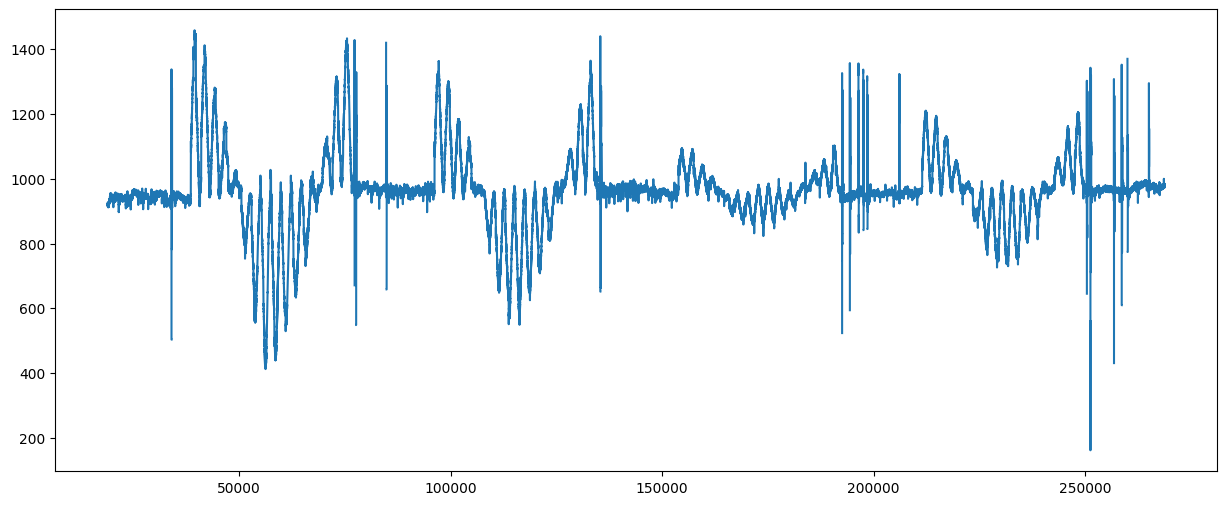

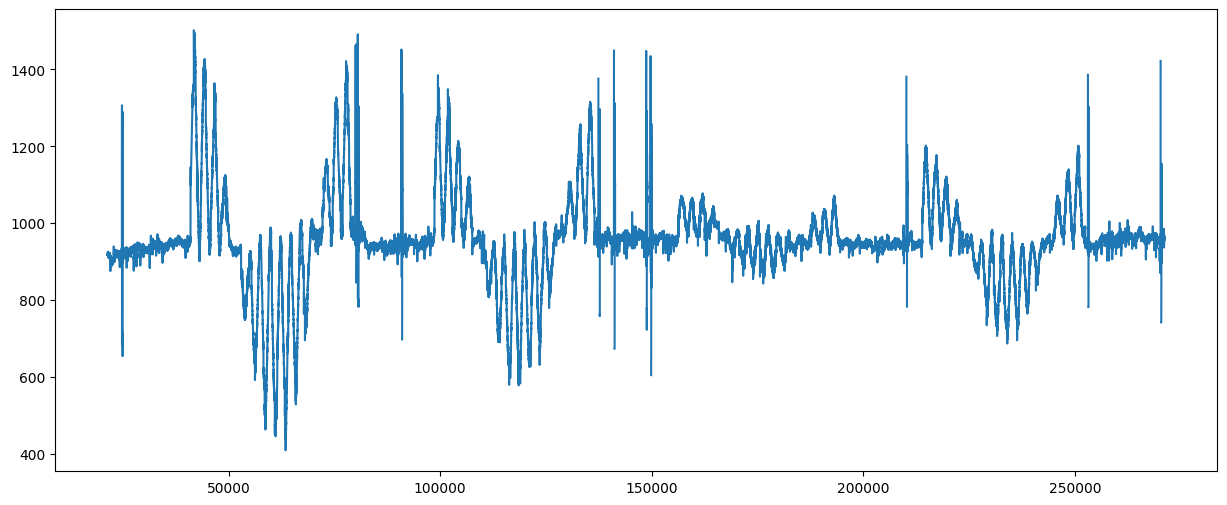

In [59]:
# Extract triggers
# Initialize arrays to store results
eye_data_runs_list = []

time_start_eye = np.zeros((1, num_run))
time_end_eye = np.zeros((1, num_run))
time_start_seq = np.zeros((num_seq, num_run))
time_end_seq = np.zeros((num_seq, num_run))
time_start_trial = np.zeros((seq_trs, num_seq, num_run))
time_end_trial = np.zeros((seq_trs, num_seq, num_run))

# Lists to collect record lines
record_lines = []
ongoing_trials = {}

# Regex patterns for matching
record_start_pattern = r'RECORD_START'
record_stop_pattern = r'RECORD_STOP'
seq_start_pattern = r'sequence\s(\d+)\sstarted'
seq_stop_pattern = r'sequence\s(\d+)\sstopped'
trial_onset_pattern = r'trial\s(\d+)\sonset'
trial_offset_pattern = r'trial\s(\d+)\soffset'
seq_9_stop_pattern = settings.get("first_trial_pattern")
seq_1_start_pattern = settings.get("last_trial_pattern")

# Loop through the 'messages' column to extract the patterns
for run_idx, df in enumerate(df_event_runs):
    for index, row in df.iterrows():
        message = row['message']
        
        if pd.isna(message):
            continue  # Skip if NaN
        
        # Check for RECORD_START and RECORD_STOP
        if re.search(record_start_pattern, message):
            record_lines.append(row['onset'])
        elif re.search(record_stop_pattern, message):
            record_lines.append(row['onset'])
        
        # Check for sequence 1 started
        if re.search(seq_1_start_pattern, message):
            time_start_eye[0, run_idx] = row['onset']  # Store by run index
            

        # Check for sequence start
        seq_start_match = re.search(seq_start_pattern, message)
        if seq_start_match:
            seq_num = int(seq_start_match.group(1))
            last_seq_num = seq_num  # Save sequence number for trial matching
            time_start_seq[seq_num - 1, run_idx] = row['onset']  

        # Check for sequence stop
        seq_stop_match = re.search(seq_stop_pattern, message)
        if seq_stop_match:
            seq_num = int(seq_stop_match.group(1))
            time_end_seq[seq_num - 1, run_idx] = row['onset']  
        # Check for sequence stop
        seq_stop_match = re.search(seq_stop_pattern, message)
        if seq_stop_match:
            seq_num = int(seq_stop_match.group(1))
            time_end_seq[seq_num - 1, run_idx] = row['onset']

        # Check for trial onset
        trial_onset_match = re.search(trial_onset_pattern, message)
        if trial_onset_match:
            trial_num = int(trial_onset_match.group(1))
            if last_seq_num is not None:  # Ensure sequence has been identified
                time_start_trial[trial_num - 1, last_seq_num - 1, run_idx] = row['onset']
                # Store ongoing trial in case offset is found later
                ongoing_trials[trial_num] = row['onset']

        # Check for trial offset (ensure it's stored after the onset)
        trial_offset_match = re.search(trial_offset_pattern, message)
        if trial_offset_match:
            trial_num = int(trial_offset_match.group(1))
            # Check if this trial has an ongoing onset recorded
            if trial_num in ongoing_trials:
                if last_seq_num is not None:
                    time_end_trial[trial_num - 1, last_seq_num - 1, run_idx] = row['onset']
                    del ongoing_trials[trial_num]  # Remove from ongoing trials as offset is found
            else:
                # Trial offset found without a matching onset, this means it was out of order
                print(f"Out-of-order trial offset found for trial {trial_num}, but onset wasn't found.")
            


        # Check for sequence 9 stopped
        if re.search(seq_9_stop_pattern, message):
            time_end_eye[0, run_idx] = row['onset']
            
            
    
    # Filter for only timestamps between first and last trial 
    eye_data_run = df_data_runs[run_idx][(df_data_runs[run_idx]['timestamp'] >= time_start_eye[0, run_idx]) & 
                       (df_data_runs[run_idx]['timestamp'] <= time_end_eye[0, run_idx])]
    
    plt_1 = plt.figure(figsize=(15, 6))
    plt.plot(eye_data_run['x_coordinate'])
    plt.show()

    eye_data_run_array = eye_data_run[['timestamp', 'x_coordinate', 'y_coordinate', 'pupil_size']].to_numpy()

    eye_data_runs_list.append(eye_data_run_array)

            

 - blink replacement with NaN
 - blink replacement with NaN


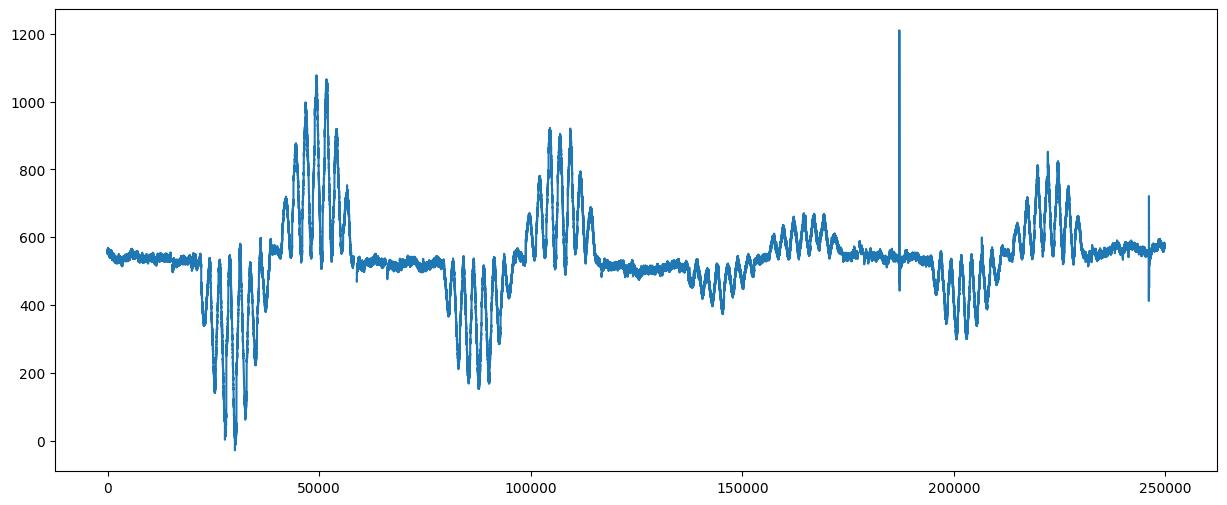

In [60]:
# Remove blinks 
# Put nan for blink time

if blinks_rm == 'pupil_off':
    eye_data_runs_nan_blink_run_1 = blinkrm_pupil_off(eye_data_runs_list[0],eyetracking_sampling)
    eye_data_runs_nan_blink_run_2 = blinkrm_pupil_off(eye_data_runs_list[1],eyetracking_sampling)

    plt_2 = plt.figure(figsize=(15, 6))
    plt.plot(eye_data_runs_nan_blink_run_1[:,2])
    plt.show()
else: 
    print("No blink removal method specified")


In [7]:
def find_zero_indices(arr):
    zero_indices = []
    # Iterate through each element in the multidimensional array
    for i, row in enumerate(arr):
        for j, elem in enumerate(row):
            # Check if the element is 0 and the column index (j) is odd
            if np.any(elem == 0) and j % 2 == 1:
                zero_indices.append((i, j))
    return zero_indices



to_check_arrays = [time_start_eye, time_end_eye, time_start_seq, time_end_seq, time_start_trial, time_end_trial]


for arr in to_check_arrays:
    print(find_zero_indices(arr))


[]
[]
[]
[]
[]
[]


In [79]:
# sub 04 
time_start_trial[0,0,0] = 28753515
time_start_trial[0,1,0] = 28772806 # trial, seq, run 


In [62]:
print(screen_size[0]/2)
print(screen_size[1]/2)

960.0
540.0


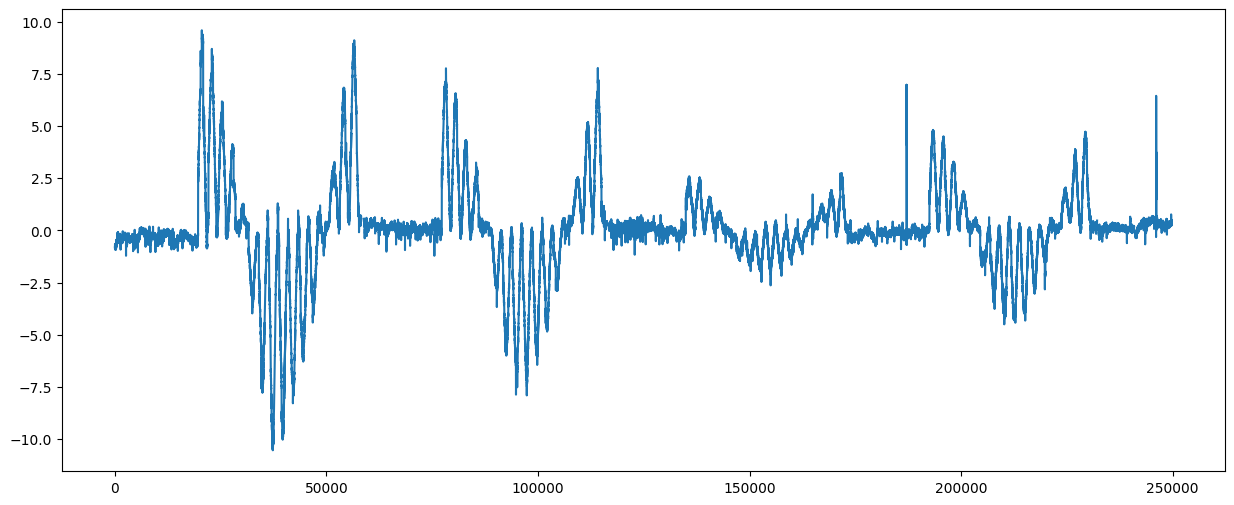

In [7]:
# Center, flip Y axis and convert to dva 
eye_data_runs[:,1] = (eye_data_runs[:,1] - (screen_size[0]/2))/ppd
eye_data_runs[:,2] = -1.0*((eye_data_runs[:,2] - (screen_size[1]/2))/ppd)

eye_data_runs_nan_blink[:,1] = (eye_data_runs_nan_blink[:,1] - (screen_size[0]/2))/ppd
eye_data_runs_nan_blink[:,2] = -1.0*((eye_data_runs_nan_blink[:,2] - (screen_size[1]/2))/ppd)

eye_data_runs_nan_blink_run_1[:,1] = (eye_data_runs_nan_blink_run_1[:,1] - (screen_size[0]/2))/ppd
eye_data_runs_nan_blink_run_1[:,2] = -1.0*((eye_data_runs_nan_blink_run_1[:,2] - (screen_size[1]/2))/ppd)

eye_data_runs_nan_blink_run_2[:,1] = (eye_data_runs_nan_blink_run_2[:,1] - (screen_size[0]/2))/ppd
eye_data_runs_nan_blink_run_2[:,2] = -1.0*((eye_data_runs_nan_blink_run_2[:,2] - (screen_size[1]/2))/ppd)

plt_3 = plt.figure(figsize=(15, 6))
plt.plot(eye_data_runs_nan_blink_run_1[:,1])
plt.show()

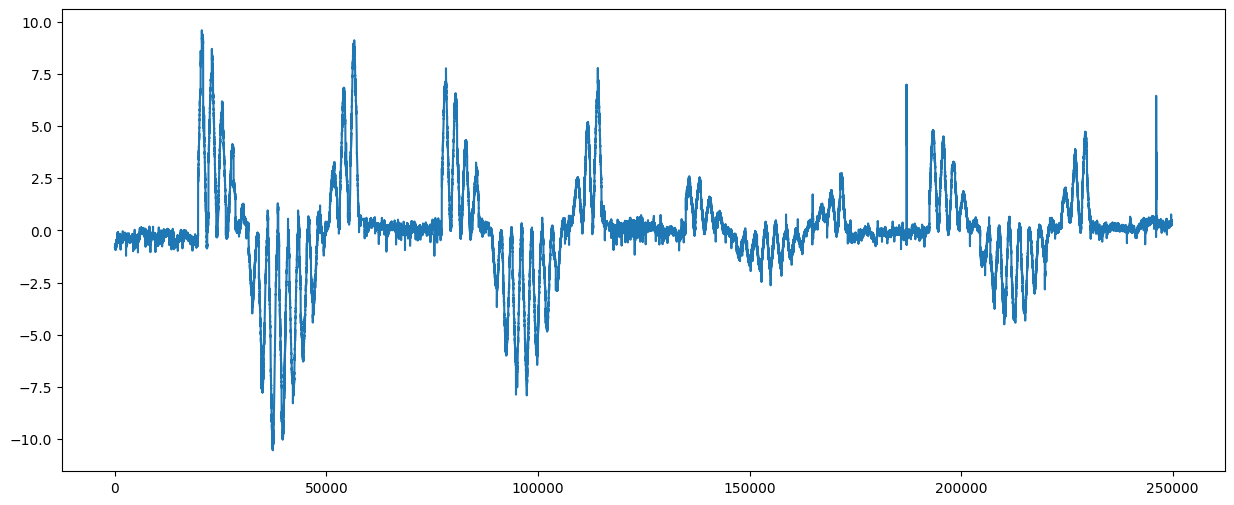

In [8]:
# interpolate nans

eye_data_x_run_01_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_1[:,1])
eye_data_y_run_01_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_1[:,2])
eye_data_p_run_01_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_1[:,3])


eye_data_x_run_02_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_2[:,1])
eye_data_y_run_02_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_2[:,2])
eye_data_p_run_02_nan_blink_interpol = interpol_nans(eye_data_runs_nan_blink_run_2[:,3])

plt_3 = plt.figure(figsize=(15, 6))
plt.plot(eye_data_x_run_01_nan_blink_interpol)
plt.show()

In [9]:
# normalise pupil size to values between -1 and 1 

import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1)) # scale between -1 and 1 

eye_data_p_run_01_nan_blink_interpol_norm = scaler.fit_transform(eye_data_p_run_01_nan_blink_interpol.reshape(-1, 1))
eye_data_p_run_01_nan_blink_interpol_norm = eye_data_p_run_01_nan_blink_interpol_norm.flatten()
eye_data_p_run_02_nan_blink_interpol_norm = scaler.fit_transform(eye_data_p_run_02_nan_blink_interpol.reshape(-1, 1))
eye_data_p_run_02_nan_blink_interpol_norm = eye_data_p_run_02_nan_blink_interpol_norm.flatten()

Executing drift correction with linear method


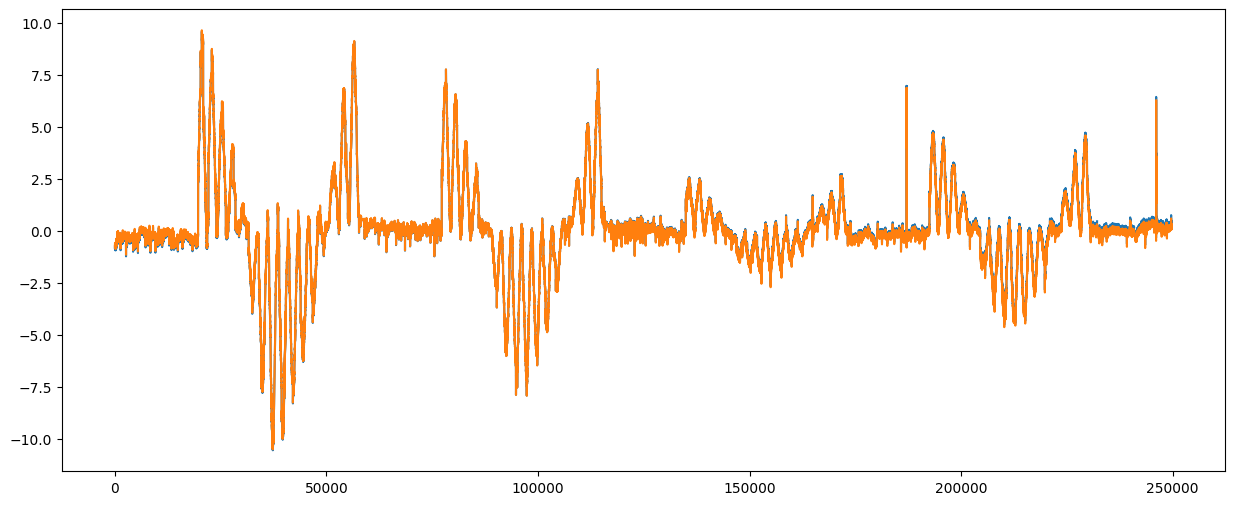

In [10]:
# drift correction

# calculate median for fixation sequences 
# substract median from whole time series

from scipy.signal import detrend

if drift_corr == "linear":
    print(f"Executing drift correction with {drift_corr} method")
    eye_data_x_run_01_nan_blink_interpol_detrend = detrend(eye_data_x_run_01_nan_blink_interpol, type='linear')
    eye_data_y_run_01_nan_blink_interpol_detrend = detrend(eye_data_x_run_01_nan_blink_interpol, type='linear')

    eye_data_x_run_02_nan_blink_interpol_detrend = detrend(eye_data_x_run_02_nan_blink_interpol, type='linear')
    eye_data_y_run_02_nan_blink_interpol_detrend = detrend(eye_data_x_run_02_nan_blink_interpol, type='linear')

    plt_4 = plt.figure(figsize=(15, 6))
    plt.plot(eye_data_runs_nan_blink_run_1[:,1])
    plt.plot(eye_data_x_run_01_nan_blink_interpol_detrend)
    plt.show()

elif drift_corr == 'median': 
    print(f"Executing drift correction with {drift_corr} method")
    eye_fix_seq = settings.get("eye_fix_seq")
    fixation_periods = []

    #Filter for fixation sequences
    for seq in eye_fix_seq:
        seq_eye_data_logic = np.logical_and(eye_data_runs_nan_blink_run_1[:,0] >= time_start_seq[seq,0],\
                                                            eye_data_runs_nan_blink_run_1[:,0] <= time_end_seq[seq,0])

        fixation_periods.append(eye_data_x_run_01_nan_blink_interpol[seq_eye_data_logic]) 


    fixation_periods_median = median([item for row in fixation_periods for item in row])        
    eye_data_x_run_01_nan_blink_interpol_detrend = np.array([elem - fixation_periods_median for elem in list(eye_data_x_run_01_nan_blink_interpol)])
    eye_data_y_run_01_nan_blink_interpol_detrend = np.array([elem - fixation_periods_median for elem in list(eye_data_y_run_01_nan_blink_interpol)])

    eye_data_x_run_02_nan_blink_interpol_detrend = np.array([elem - fixation_periods_median for elem in list(eye_data_x_run_02_nan_blink_interpol)])
    eye_data_y_run_02_nan_blink_interpol_detrend = np.array([elem - fixation_periods_median for elem in list(eye_data_y_run_02_nan_blink_interpol)])

else: 
    print("No detrending method specified")

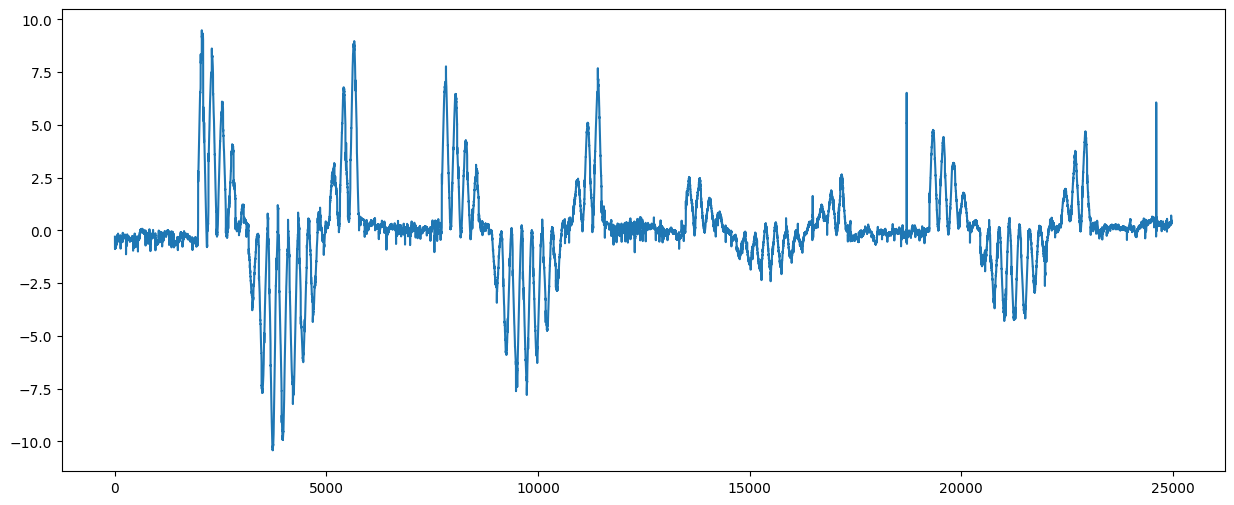

In [27]:
# downsampling to target rate 
if downsampling: 

    eye_data_x_run_01_nan_blink_interpol_detrend_ds = downsample_to_targetrate(eye_data_x_run_01_nan_blink_interpol_detrend, 1000, 100)

    plt_5 = plt.figure(figsize=(15, 6))
    plt.plot(eye_data_x_run_01_nan_blink_interpol_detrend_ds)
    plt.show()

else: 
    print("Skipping downsampling")

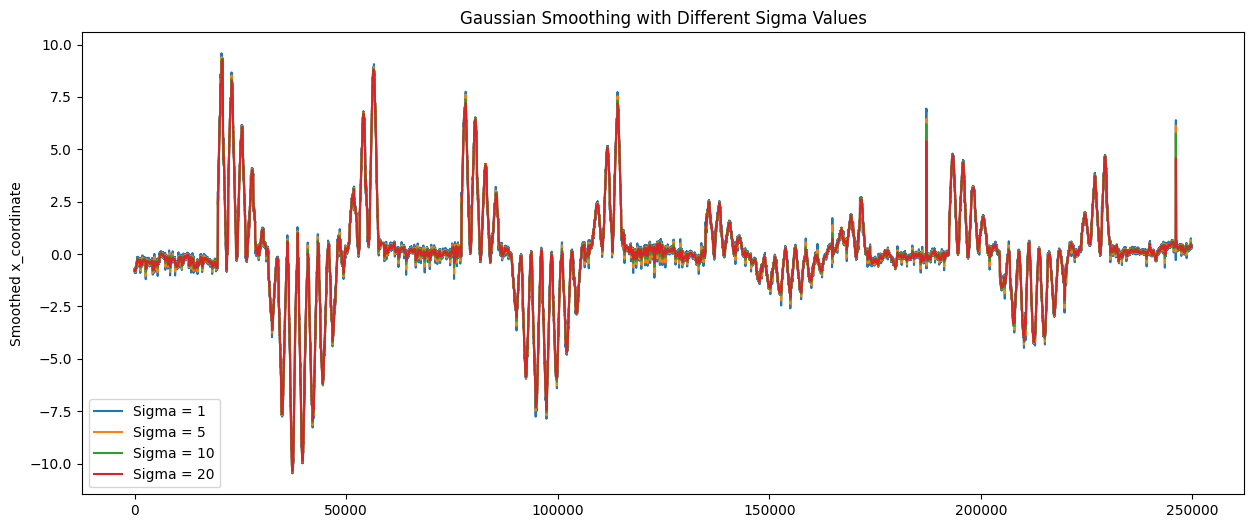

In [50]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigmas = [1, 5, 10, 20]  
plt.figure(figsize=(15, 6))

for sigma in sigmas:
    smoothed_x = gaussian_filter1d(eye_data_x_run_01_nan_blink_interpol, sigma=sigma)
    plt.plot(smoothed_x, label=f'Sigma = {sigma}')

plt.legend()
plt.title('Gaussian Smoothing with Different Sigma Values')
plt.ylabel('Smoothed x_coordinate')
plt.show()


Smoothing with moving_avg method
Saving cleaned data...
Smoothing with moving_avg method
Saving cleaned data...


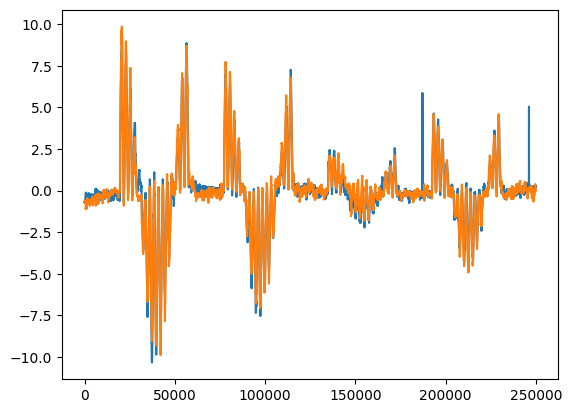

In [13]:
# Smoothing 
# Saving 
smoothing = 'moving_avg'

eye_data_run_01_nan_blink_interpol_detrend = np.stack((eye_data_runs_nan_blink_run_1[:,0],
                                                       eye_data_x_run_01_nan_blink_interpol_detrend, 
                                                       eye_data_y_run_01_nan_blink_interpol_detrend, 
                                                       eye_data_p_run_01_nan_blink_interpol), axis=1)

eye_data_run_02_nan_blink_interpol_detrend = np.stack((eye_data_runs_nan_blink_run_2[:,0],
                                                       eye_data_x_run_02_nan_blink_interpol_detrend, 
                                                       eye_data_y_run_02_nan_blink_interpol_detrend, 
                                                       eye_data_p_run_02_nan_blink_interpol), axis=1)

eye_data_runs_list_nan_blink = [eye_data_run_01_nan_blink_interpol_detrend, eye_data_run_02_nan_blink_interpol_detrend]

for run in range(len(eye_data_runs_list_nan_blink)):

    # Convert the NumPy array back into a DataFrame
    eye_data_runs_df = pd.DataFrame(eye_data_runs_list_nan_blink[run], columns=['timestamp', 'x_coordinate', 'y_coordinate', 'pupil_size'])

    if smoothing: 
        if smoothing == 'moving_avg': 
            print(f"Smoothing with {smoothing} method")

            # Define window size
            moving_average_smoothing(eye_data_runs_df, 1000, 50)

            plt.plot(eye_data_runs_df['x_coordinate'])
        elif smoothing == 'gaussian': 
            print(f"Smoothing with {smoothing} method")
            sigma = settings.get("sigma")
            # Apply Gaussian smoothing to both x and y coordinates using fast convolution
            eye_data_runs_df['x_coordinate'] = gaussian_smoothing(eye_data_runs_df, 'x_coordinate', sigma)
            eye_data_runs_df['y_coordinate'] = gaussian_smoothing(eye_data_runs_df, 'y_coordinate', sigma)

            plt.plot(eye_data_runs_df['x_coordinate'])
        else:
            print(f"Unknown smoothing method: {smoothing}, skipping smoothing.")
    else:
        print("No smoothing specified, skipping smoothing.")

    # Saving data (whether smoothed or not)
    print("Saving cleaned data...")
    
    # Create directory if it doesn't exist
    if not os.path.exists(f"{file_dir_save}/timeseries"):
        os.makedirs(f"{file_dir_save}/timeseries")
    
    # File path for the compressed TSV file
    tsv_file = f'{file_dir_save}/timeseries/{subject}_task-{task}_run_0{run + 1}_eyedata.tsv.gz'

    # Save the DataFrame to a .tsv.gz file with compression
    eye_data_runs_df.to_csv(tsv_file, sep='\t', index=False, compression='gzip')



In [198]:
# get amplitude sequence from event files

#? Probaly wont need this here, can extract in saccade script directly 
dfs = []
legend_amp = {1: 4, 2: 6, 3: 8, 4: 10, 5: "none"}
    
for file_path in data_events:
	df = pd.read_csv(file_path, sep='\t')
	dfs.append(df)

appended_df = pd.concat(dfs, ignore_index=True)
amp_sequence_ev = list(appended_df['eyemov_amplitude'])

amp_sequence = [legend_amp[val] if not math.isnan(val) else float('nan') for val in amp_sequence_ev]

In [14]:
# Save trigger stats

if not os.path.exists(f"{file_dir_save}/stats"): 
    os.makedirs(f"{file_dir_save}/stats") 

columns = columns = ['Trial', 'Seq', 'Run', 'Exp_Start', 'Exp_End', 'Seq_Start', 'Seq_End', 'Trial_Start', 'Trial_End']
data = []
trial_count = 1

# Loop through sequences
for seq in range(num_seq): 
    num_trials = trials_seq[seq]  # Get number of trials for current sequence
    for trial in range(num_trials):
        for run in range(num_run): 
            # Only add Eye_Start for the very first trial (trial_count == 1)
            if trial_count == 1:
                eye_start = time_start_eye[0, run]
            else:
                eye_start = ''
                
            # Only add Eye_End for the very last trial 
            if trial_count == sum(trials_seq):
                eye_end = time_end_eye[0, run]
            else:
                eye_end = ''

            # Only add Seq_Start for the first trial of the sequence
            if trial == 0:
                seq_start = time_start_seq[seq, run]
            else:
                seq_start = ''
                
            # Only add Seq_End for the last trial of the sequence
            if trial == num_trials - 1:
                seq_end = time_end_seq[seq, run]
            else:
                seq_end = ''
                
            
            # Append the data
            data.append([
                trial_count,
                seq + 1,
                run + 1,
                eye_start,
                eye_end,
                seq_start,
                seq_end,
                time_start_trial[trial, seq, run],
                time_end_trial[trial, seq, run] 
            ])
            
        # Increment trial count
        trial_count += 1

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=columns)


#TODO append any other experimental settings here ? 

for run in range(num_run):
    # Separate data for Run 1 and Run 2
    df_run1 = df[df['Run'] == run + 1]
    df_run2 = df[df['Run'] == run + 1]

    # Save each run's data into separate TSV files
    df_run1.to_csv(f'{file_dir_save}/stats/{subject}_task-{task}_run-{run+1}_eyedata_stats.tsv', sep='\t', index=False)
    df_run2.to_csv(f'{file_dir_save}/stats/{subject}_task-{task}_run-{run+1}_eyedata_stats.tsv', sep='\t', index=False)


In [54]:
#!! Checking how tsv files can be read back in 
# original format for easier later use

df_run1 = pd.read_csv("/Users/sinakling/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-01/eyetracking/stats/sub-01_task-PurLoc_run-1_eyedata_stats.tsv", sep="\t",na_values=[''])
df_run2 = pd.read_csv("/Users/sinakling/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-01/eyetracking/stats/sub-01_task-PurLoc_run-2_eyedata_stats.tsv", sep="\t",na_values=[''])

time_start_eye = np.zeros((1, num_run))
time_end_eye = np.zeros((1, num_run))
time_start_seq = np.zeros((num_seq, num_run))
time_end_seq = np.zeros((num_seq, num_run))
time_start_trial = np.zeros((seq_trs, num_seq, num_run))
time_end_trial = np.zeros((seq_trs, num_seq, num_run))

dataframes = [df_run1, df_run2]
# Loop through the DataFrame

for dataf in dataframes: 
    for index, row in dataf.iterrows():
        trial = int(row['Trial'] - 1)  
        seq = int(row['Seq'] - 1)     
        run = int(row['Run'] - 1)      
        
        if trial < seq_trs:  # problem
            time_start_trial[trial, seq, run] = row['Trial_Start']
            time_end_trial[trial, seq, run] = row['Trial_End']
        else:
            pass
        
        # Fill in time_start_seq and time_end_seq
        if pd.notna(row['Seq_Start']):  
            time_start_seq[seq, run] = row['Seq_Start']
        if pd.notna(row['Seq_End']):  
            time_end_seq[seq, run] = row['Seq_End']
            
        #  handle for first and last trials
        if trial == 0 and index == 0:  # First trial
            time_start_eye[0, run] = row['Exp_Start']
        if trial == (dataf.shape[0] - 1) and index == (dataf.shape[0] - 1):  # Last trial
            time_end_eye[0, run] = row['Exp_End']

    


In [ ]:
# save as h5 



if not os.path.exists(f"{file_dir_save}/stats"): 
    os.makedirs(f"{file_dir_save}/stats") 


# Loop over each run
for run_idx in range(num_run):
    h5_file = '{file_dir}/{sub}/{sub}_task-{task}_run-{run}_eyedata_stats.h5'.format(
        file_dir=file_dir_save, sub=subject, task=task, run=run_idx + 1)
    
    # Remove existing file if it exists
    try:
        os.system(f'rm "{h5_file}"')
    except:
        pass

    # Open a new HDF5 file for this run
    with h5py.File(h5_file, "a") as h5file:
        # Create datasets for this run
        h5file.create_dataset(f'eye_data_runs_nan_blink', data=eye_data_runs_nan_blink[run_idx], dtype='float32')
        h5file.create_dataset(f'time_start_eye', data=time_start_eye[:, run_idx], dtype='float32')
        h5file.create_dataset(f'time_end_eye', data=time_end_eye[:, run_idx], dtype='float32')
        h5file.create_dataset(f'time_start_seq', data=time_start_seq[:, run_idx], dtype='float32')
        h5file.create_dataset(f'time_end_seq', data=time_end_seq[:, run_idx], dtype='float64')
        h5file.create_dataset(f'time_start_trial', data=time_start_trial[:, :, run_idx], dtype='float32')
        h5file.create_dataset(f'time_end_trial', data=time_end_trial[:, :, run_idx], dtype='float32')
        h5file.create_dataset(f'amp_sequence', data=amp_sequence_ev[run_idx], dtype='float32')
        
